In [1]:
import warnings

from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpyro

from matplotlib import MatplotlibDeprecationWarning
from numpy.random import default_rng

warnings.filterwarnings(action="ignore")

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# %config InlineBackend.figure_format = 'retina'
# az.style.use("arviz-darkgrid")

In [2]:
# load data:
data = pd.read_csv('data/anemones.csv')

In [3]:
data.shape

(231, 3)

In [4]:
data.head()

,x,y,marks
0,27,7,6
1,197,5,4
2,74,15,4
3,214,18,6
4,121,22,3


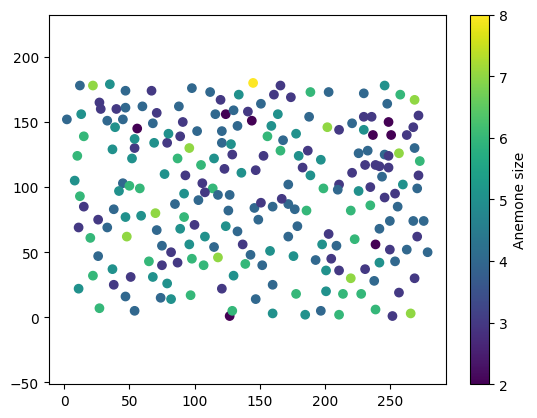

In [6]:
plt.scatter(data["x"], data["y"], c=data["marks"])
plt.colorbar(label="Anemone size")
plt.axis("equal");

In [7]:
xy = data[["x", "y"]].values

# Jitter the data slightly so that none of the points fall exactly
# on cell boundaries
eps = 1e-3
rng = default_rng()
xy = xy.astype("float") + rng.standard_normal(xy.shape) * eps

resolution = 20

# Rescaling the unit of area so that our parameter estimates
# are easier to read
area_per_cell = resolution**2 / 100

cells_x = int(280 / resolution)
cells_y = int(180 / resolution)

# Creating bin edges for a 2D histogram
quadrat_x = np.linspace(0, 280, cells_x + 1)
quadrat_y = np.linspace(0, 180, cells_y + 1)

# Identifying the midpoints of each grid cell
centroids = np.asarray(list(product(quadrat_x[:-1] + 10, quadrat_y[:-1] + 10)))

cell_counts, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts = cell_counts.ravel().astype(int)

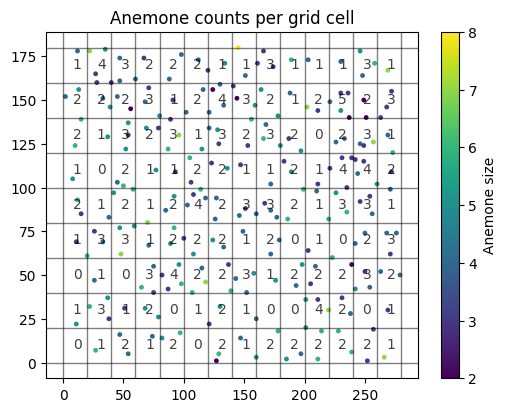

In [8]:
line_kwargs = {"color": "k", "linewidth": 1, "alpha": 0.5}

plt.figure(figsize=(6, 4.5))
[plt.axhline(y, **line_kwargs) for y in quadrat_y]
[plt.axvline(x, **line_kwargs) for x in quadrat_x]
plt.scatter(data["x"], data["y"], c=data["marks"], s=6)

for i, row in enumerate(centroids):
    shifted_row = row - 2
    plt.annotate(cell_counts[i], shifted_row, alpha=0.75)

plt.title("Anemone counts per grid cell"), plt.colorbar(label="Anemone size");

In [9]:
cell_counts

array([0, 1, 0, 1, 2, 1, 2, 2, 1, 1, 3, 1, 3, 1, 0, 1, 2, 4, 2, 1, 0, 3,
       2, 2, 3, 2, 3, 1, 2, 3, 1, 1, 1, 2, 3, 2, 2, 0, 4, 2, 2, 1, 3, 1,
       2, 0, 1, 2, 2, 4, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 1, 1, 1, 3,
       1, 3, 1, 2, 3, 1, 2, 0, 1, 2, 3, 1, 3, 2, 3, 2, 0, 2, 0, 2, 2, 2,
       1, 1, 2, 4, 2, 1, 1, 1, 0, 2, 1, 2, 2, 2, 0, 3, 4, 2, 5, 1, 2, 0,
       3, 2, 3, 4, 3, 2, 3, 1, 1, 2, 3, 1, 2, 1, 3, 1])

In [ ]:
cell_counts, centroids, area_per_cell 

In [10]:
import numpyro

In [12]:
import pprint

## Inference

In [ ]:
# import numpy as np

# import numpyro
# import numpyro.distributions as dist
# from numpyro.infer import MCMC, NUTS, Predictive
# from numpyro.diagnostics import hpdi

# import jax
# import jax.numpy as jnp

# # check number of devices available
# num_device = jax.local_device_count()
# print("Number of available devices: ", num_device)
# numpyro.set_host_device_count(1)

# import arviz as az

# import matplotlib.pyplot as plt

Number of available devices:  1


In [39]:
np.random.seed(42)
rng_key = jax.random.PRNGKey(42)

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro import sample, deterministic
import arviz as az
import matplotlib.pyplot as plt
from numpyro.infer import MCMC, NUTS, Predictive

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Matern52Kernel:
    def __init__(self, variance, lengthscale):
        self.variance = variance
        self.lengthscale = lengthscale
    
    def __call__(self, x1, x2):
        # Compute pairwise distances
        diff = x1[:, None, :] - x2[None, :, :]
        scaled_dist = jnp.sqrt(5) * jnp.linalg.norm(diff, axis=-1) / self.lengthscale
        
        # Compute Matern 5/2 kernel
        kernel_matrix = self.variance * (1 + scaled_dist + (scaled_dist**2)/3) * jnp.exp(-scaled_dist)
        
        return kernel_matrix

def make_positive_definite(matrix, min_eigval=1e-6):
    """
    Ensure matrix is positive definite by adding diagonal jitter
    
    Args:
        matrix (jnp.ndarray): Input matrix
        min_eigval (float): Minimum eigenvalue to ensure
    
    Returns:
        jnp.ndarray: Positive definite matrix
    """
    # Symmetrize the matrix
    matrix = 0.5 * (matrix + matrix.T)
    
    # Compute eigendecomposition
    eigvals, eigvecs = jnp.linalg.eigh(matrix)
    
    # Clip eigenvalues to ensure positive definiteness
    eigvals = jnp.maximum(eigvals, min_eigval)
    
    # Reconstruct matrix
    return eigvecs @ jnp.diag(eigvals) @ eigvecs.T

def model(centroids, cell_counts, area_per_cell, X_pred=None):
    # Prior for mean
    mu = sample("mu", dist.Normal(0, 3))
    
    # Prior for length scale
    rho = sample("rho", dist.Uniform(25, 300))
    
    # Prior for variance using InverseGamma directly
    variance = sample("variance", dist.InverseGamma(1.0, 1.0))
    
    # Construct covariance function
    kernel = Matern52Kernel(variance, rho)
    cov_matrix = kernel(centroids, centroids)
    
    # Ensure positive definiteness
    cov_matrix = make_positive_definite(cov_matrix)
    
    # Log intensity as multivariate normal
    log_intensity = sample("log_intensity", 
                           dist.MultivariateNormal(
                               loc=jnp.full(len(centroids), mu), 
                               covariance_matrix=cov_matrix
                           ))
    
    # Intensity and Poisson likelihood
    intensity = jnp.exp(log_intensity)
    rates = intensity * area_per_cell
    
    with numpyro.plate("observations", len(cell_counts)):
        sample("counts", 
               dist.Poisson(rates), 
               obs=cell_counts)
    
    # Conditional sampling for prediction points if provided
    if X_pred is not None:
        # Compute predictive distribution
        full_cov = kernel(centroids, centroids)
        full_cov = make_positive_definite(full_cov)
        cross_cov = kernel(centroids, X_pred)
        pred_cov = kernel(X_pred, X_pred)
        pred_cov = make_positive_definite(pred_cov)
        
        # Compute conditional distribution
        # Use Woodbury matrix identity for more numerically stable computations
        inv_cov = jnp.linalg.inv(full_cov)
        conditional_mean = mu + cross_cov.T @ inv_cov @ (log_intensity - mu)
        
        # Compute conditional covariance more carefully
        schur_complement = pred_cov - cross_cov.T @ inv_cov @ cross_cov
        conditional_cov = make_positive_definite(schur_complement)
        
        # Sample conditional log intensity
        log_intensity_pred = sample("log_intensity_pred", 
                                    dist.MultivariateNormal(
                                        loc=conditional_mean, 
                                        covariance_matrix=conditional_cov
                                    ))
        return log_intensity_pred

def run_lgcp_analysis(data, centroids, cell_counts, area_per_cell):
    # Create prediction grid
    x_new = jnp.linspace(data['x'].min(), data['x'].max(), 20)
    y_new = jnp.linspace(data['y'].min(), data['y'].max(), 20)
    xs, ys = jnp.meshgrid(x_new, y_new)
    xy_new = jnp.column_stack([xs.ravel(), ys.ravel()])
    
    # MCMC sampling
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=2000, num_samples=1000)
    
    rng_key = jax.random.PRNGKey(0)
    mcmc.run(rng_key, centroids, cell_counts, area_per_cell, X_pred=xy_new)
    
    # Convert to ArviZ format
    trace = az.from_numpyro(mcmc)
    
    # Posterior predictive sampling
    predictive = Predictive(model, mcmc.get_samples())
    pred_rng_key = jax.random.PRNGKey(1)
    posterior_pred = predictive(pred_rng_key, centroids, cell_counts, area_per_cell, X_pred=xy_new)
    
    # Visualization of posterior samples
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
    axes = axes.ravel()
    
    intensity_samples = jnp.exp(posterior_pred['log_intensity_pred'])
    
    for i in range(6):
        field_handle = axes[i].scatter(
            xy_new[:, 0], xy_new[:, 1], 
            c=intensity_samples[i], 
            cmap='viridis',
            marker='o', 
            edgecolor='None', 
            alpha=0.7, 
            s=80
        )
        obs_handle = axes[i].scatter(data['x'], data['y'], s=10, color='k')
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i}')
    
    plt.figlegend(
        (obs_handle, field_handle),
        ('Observed data', r'Posterior draws of $\lambda(s)$'),
        ncol=2,
        loc=(0.2, -0.01),
        fontsize=14,
        frameon=False
    )
    plt.suptitle('Log-Gaussian Cox Process Posterior Intensity')
    plt.show()
    
    return trace, posterior_pred



sample: 100%|██████████| 3000/3000 [03:13<00:00, 15.53it/s, 1 steps of size 1.18e-38. acc. prob=0.00]


KeyError: 'log_intensity_pred'

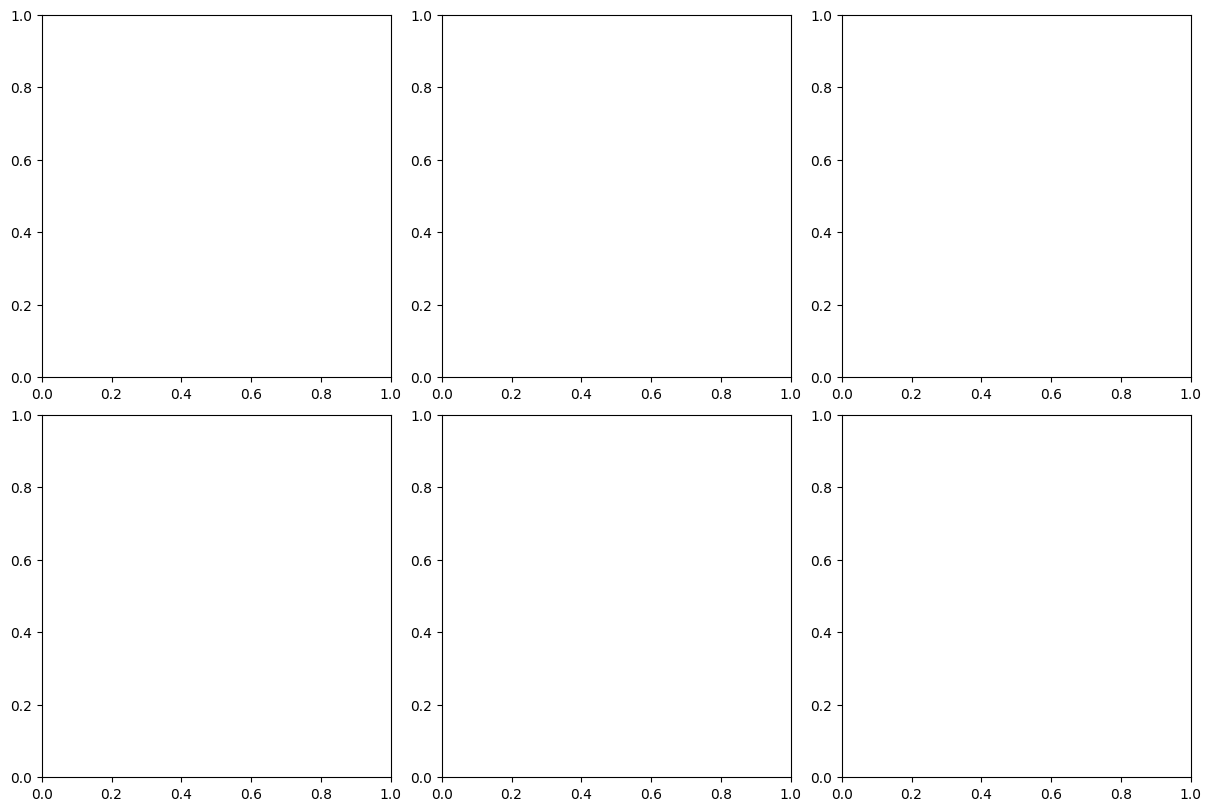

In [3]:
# Example usage (you would replace this with your actual data)
def prepare_example_data():
    import numpy as np
    
    # Simulate some example data
    np.random.seed(42)
    x = np.random.uniform(0, 300, 10)
    y = np.random.uniform(0, 200, 10)
    
    # Create centroids (grid of points)
    x_cents = np.linspace(x.min(), x.max(), 2)
    y_cents = np.linspace(y.min(), y.max(), 2)
    xs, ys = np.meshgrid(x_cents, y_cents)
    centroids = np.column_stack([xs.ravel(), ys.ravel()])
    
    # Simulate cell counts (this would typically come from your actual data)
    cell_counts = np.random.poisson(10, size=len(centroids))
    
    # Area per cell (assuming uniform)
    area_per_cell = np.ones(len(centroids))
    
    return {
        'x': x,
        'y': y
    }, centroids, cell_counts, area_per_cell

# Main execution
if __name__ == "__main__":
    # Prepare data
    data, centroids, cell_counts, area_per_cell = prepare_example_data()
    
    # Run analysis
    trace, posterior_pred = run_lgcp_analysis(
        data, 
        jnp.array(centroids), 
        jnp.array(cell_counts), 
        jnp.array(area_per_cell)
    )
    
    # Print summary of trace
    print(az.summary(trace, var_names=['mu', 'rho', 'variance']))